In [1]:
# import segyio
# import numpy as np
# from shutil import copyfile
# import matplotlib.pyplot as plt

In [2]:
# CUPY_GPU_MEMORY_LIMIT="70%"

In [2]:
# %load_ext autoreload
# %autoreload 2
# %matplotlib inline

################################# FOR GPU ###############################
import os
import numpy as np

import scipy as sp
import cusignal
import matplotlib.pyplot as plt
import segyio
from scipy.signal import convolve, filtfilt

from pylops.utils                      import dottest
from pylops.utils.backend              import get_lstsq
from pylops.utils.wavelets             import *
from pylops.basicoperators             import *
from pylops.avo.avo                    import *
from pylops.avo.poststack              import *
from pylops.avo.prestack               import *
from pylops.optimization.basic         import *
from pylops.optimization.leastsquares  import *

import cupy as cp
cp.cuda.Device(device=0).use()

dtype = np.float32



# import warnings
# warnings.filterwarnings('ignore')


# Notebook #0

In [4]:
# mempool = cp.get_default_memory_pool()
# pinned_mempool = cp.get_default_pinned_memory_pool()
# with cp.cuda.Device(0):
#     mempool.set_limit(size=5.5*1024**3)

In [5]:
# mempool.free_all_blocks()
# pinned_mempool.free_all_blocks()

In [6]:
# filename = 'SEISMIC/94p07ful.sgy'
# filename = 'SEISMIC/Final_inversion_94p07_IPOPT.segy'
# filename = 'external/Kerry3D.segy'
def grid_view(segyfile):

    # Extract header word for all traces
    sourceX = segyfile.attributes(segyio.TraceField.SourceX)[:]

    # Scatter plot sources and receivers color-coded on their number
    plt.figure()
    sourceY = segyfile.attributes(segyio.TraceField.SourceY)[:]
    nsum = segyfile.attributes(segyio.TraceField.NSummedTraces)[:]
    plt.scatter(sourceX, sourceY, c=nsum, edgecolor='none')

    groupX = segyfile.attributes(segyio.TraceField.GroupX)[:]
    groupY = segyfile.attributes(segyio.TraceField.GroupY)[:]
    nstack = segyfile.attributes(segyio.TraceField.NStackedTraces)[:]
    plt.scatter(groupX, groupY, c=nstack, edgecolor='none')

## 3D

In [7]:
# %load_ext autoreload
# %autoreload 2
# %matplotlib inline

# import warnings
# warnings.filterwarnings('ignore')

# import numpy as np
# import matplotlib.pyplot as plt
# import segyio
# import pylops

Let's now read the data. 

Note that we add the `ignore_geometry=True` parameter when we open the file. As we will see the geometry in this file is not regular, so we cannot rely on the inner working of segyio to get our data into a 3d numpy array as it was the case for the Kerry3D data.

In [8]:
segyfile = '''T:\My Drive\BackUp_\ifp\MachineLearning\SEISMIC\94p07ful.sgy'''

f = segyio.open(segyfile, ignore_geometry=True)
f.mmap()

False

In [9]:
# grid_view(f)

We thus need to read all ILs, XLs and traces and reorganize them ourselves into a regular grid. No worries, numpy will do most of the hard work

In [10]:
# Geometry fix

t = f.samples
il = f.attributes(segyio.TraceField.INLINE_3D)[:]
xl = f.attributes(segyio.TraceField.CROSSLINE_3D)[:]

traces = segyio.collect(f.trace)[:]
ntraces, nt = traces.shape

# define a regular IL and XL axis
il_unique = np.unique(il)
xl_unique = np.unique(xl)

il_min, il_max = min(il_unique), max(il_unique)
xl_min, xl_max = min(xl_unique), max(xl_unique)

dt = t[1] - t[0]
dil = min(np.unique(np.diff(il_unique)))
dxl = min(np.unique(np.diff(xl_unique)))

# regular axis
ilines = np.arange(il_min, il_max + dil, dil)
xlines = np.arange(xl_min, xl_max + dxl, dxl)
nil, nxl = ilines.size, xlines.size

ilgrid, xlgrid = np.meshgrid(np.arange(nil),
                             np.arange(nxl),
                             indexing='ij')

# look-up table
traces_indeces = np.full((nil, nxl), np.nan)
iils = (il - il_min) // dil
ixls = (xl - xl_min) // dxl
traces_indeces[iils, ixls] = np.arange(ntraces)
traces_available = np.logical_not(np.isnan(traces_indeces))
print('# missing traces: {}'.format(np.sum(~traces_available)))

# reorganize traces in regular grid
d = np.zeros((nil, nxl, nt))
d[ilgrid.ravel()[traces_available.ravel()],
  xlgrid.ravel()[traces_available.ravel()]] = traces

# missing traces: 0


In [11]:
print(t.min(),t.max())

0.0 2000.0


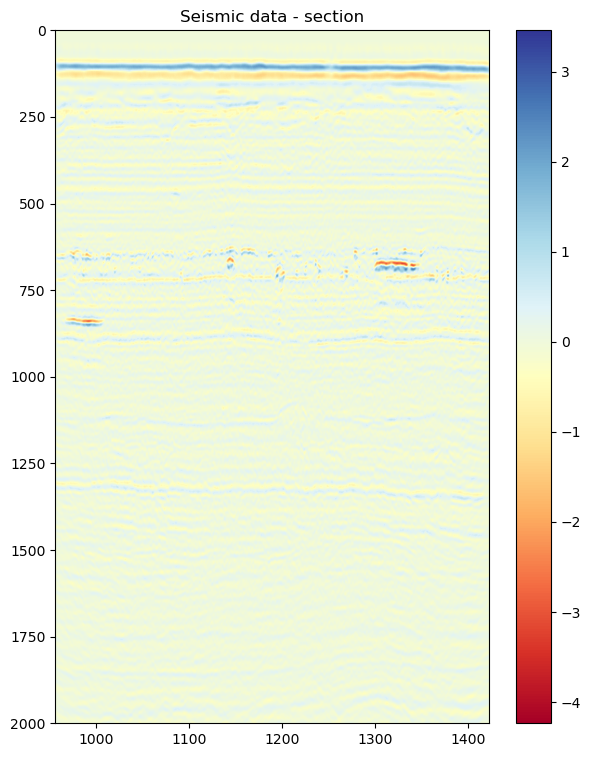

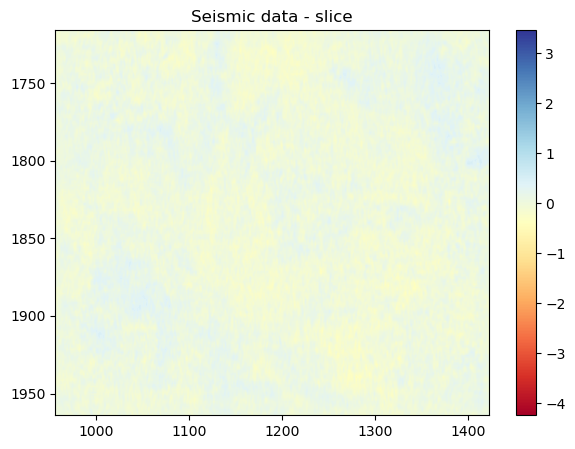

In [12]:
plt.figure(figsize=(7, 9))
plt.imshow(d[nil//2].T, cmap='RdYlBu', vmin=traces.min(), vmax=traces.max(),
           extent=(xlines[0], xlines[-1], t[-1], t[0]))
plt.title('Seismic data - section')
plt.colorbar()
plt.axis('tight');

plt.figure(figsize=(7, 5))
plt.imshow(d[..., nt//2], cmap='RdYlBu', vmin=traces.min(), vmax=traces.max(),
           extent=(xlines[0], xlines[-1], ilines[-1], ilines[0]))
plt.title('Seismic data - slice')
plt.colorbar()
plt.axis('tight');

Once again, let's estimate the wavelet and apply relative inversion. This time we will target the deeper area

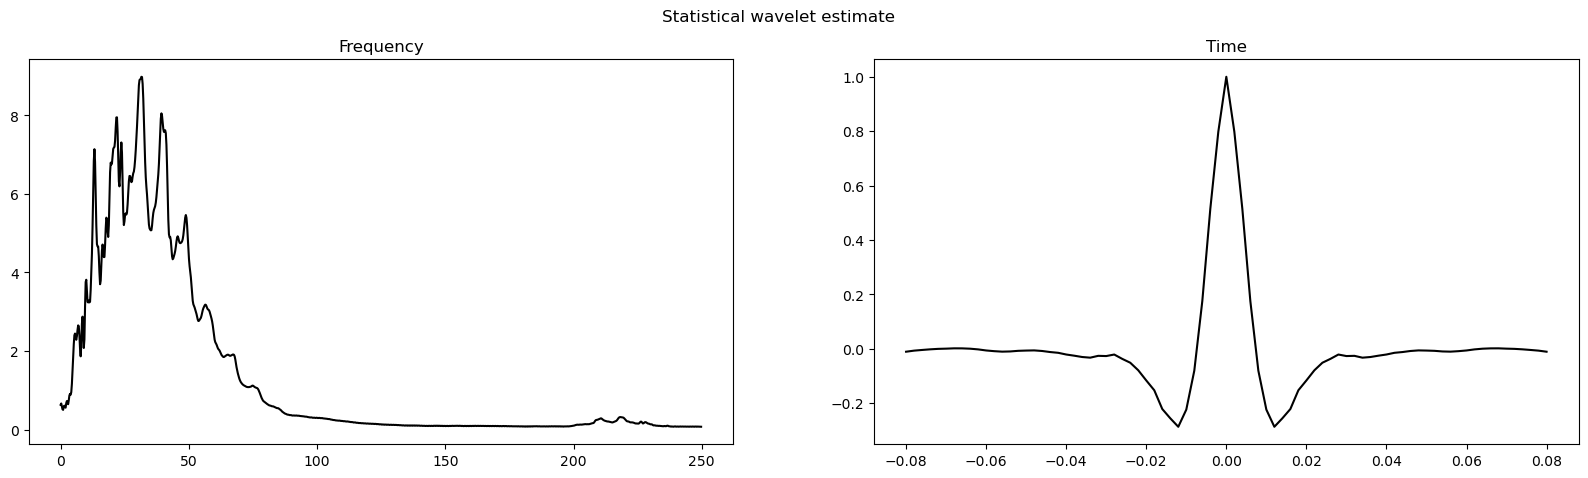

In [13]:
nt_wav = 41 # lenght of wavelet in samples
nfft = 2**11 # lenght of fft

# time axis for wavelet
t_wav = np.arange(nt_wav) * (dt/1000) 
t_wav = np.concatenate((np.flipud(-t_wav[1:]), t_wav), axis=0)

# estimate wavelet spectrum
wav_est_fft = np.mean(np.abs(np.fft.fft(d[..., 500:], nfft, axis=-1)), axis=(0, 1))
fwest = np.fft.fftfreq(nfft, d=dt/1000)

# create wavelet in time
wav_est = np.real(np.fft.ifft(wav_est_fft)[:nt_wav])
wav_est = np.concatenate((np.flipud(wav_est[1:]), wav_est), axis=0)
wav_est = wav_est / wav_est.max()
wcenter = np.argmax(np.abs(wav_est))

# display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(fwest[:nfft//2], wav_est_fft[:nfft//2], 'k')
axs[0].set_title('Frequency')
axs[1].plot(t_wav, wav_est, 'k')
axs[1].set_title('Time');

In [14]:
# swap time axis to first dimension
# itmin, itmax = t.min(),t.max()
# d_small = d[..., :]
# d_small = np.swapaxes(d_small, -1, 0)

# m_relative, r_relative = \
#     pylops.avo.poststack.PoststackInversion(d_small, wav_est, m0=np.zeros_like(d_small), explicit=True, 
#                                             epsI=1e-3, simultaneous=False)
# m_relative_reg, r_relative_reg = \
#     pylops.avo.poststack.PoststackInversion(d_small, wav_est, m0=m_relative, epsI=1e-4, epsR=5e1, 
#                                             **dict(iter_lim=20, show=2))
# # swap time axis back to last dimension
# d_small = np.swapaxes(d_small, 0, -1)
# m_relative = np.swapaxes(m_relative, 0, -1)
# m_relative_reg = np.swapaxes(m_relative_reg, 0, -1)
# r_relative = np.swapaxes(r_relative, 0, -1)
# r_relative_reg = np.swapaxes(r_relative_reg, 0, -1)

In [15]:
# ################################# FOR GPU ###############################
# import os
# import numpy as np
# import cupy as cp
# import scipy as sp
# import cusignal
# import matplotlib.pyplot as plt

# from scipy.signal import convolve, filtfilt

# from pylops.utils                      import dottest
# from pylops.utils.backend              import get_lstsq
# from pylops.utils.wavelets             import *
# from pylops.basicoperators             import *
# from pylops.avo.avo                    import *
# from pylops.avo.poststack              import *
# from pylops.avo.prestack               import *
# from pylops.optimization.basic         import *
# from pylops.optimization.leastsquares  import *
# dtype = np.float32



In [16]:
# swap time axis to first dimension
itmin, itmax = t.min(),t.max()
d_small = d[..., :]
d_small = np.swapaxes(d_small, -1, 0)
d_small_cp = cp.asarray(d_small.astype(dtype))
wav_est_cp = cp.asarray(wav_est.astype(dtype))
m0 = cp.zeros_like(d_small_cp, dtype=dtype)
# m_relative, r_relative = None, None
# mempool.free_all_blocks()
# pinned_mempool.free_all_blocks()

m_relative, r_relative = PoststackInversion(d_small_cp, wav_est_cp, m0=m0, explicit=True, epsI=1e-3,
                                            simultaneous=False, **dict(rcond=1e-5))
# m_relative, r_relative = PoststackInversion(d_small_cp, wav_est_cp, m0=np.zeros_like(d_small_cp), explicit=False, 
#                                             epsR=0.1, **dict(show=True, niter=10, damp=1e-4))
# m_relative_reg, r_relative_reg = PoststackInversion(d_small_cp, wav_est_cp, m0=m_relative,
#                                                     epsR=np.sqrt(1e2), **dict(engine='pylops', damp=np.sqrt(1e-2), niter=50))
# del m_relative
# del r_relative
# mempool.free_all_blocks()
# pinned_mempool.free_all_blocks()
# print(mempool.get_limit())  # 1073741824

In [17]:
cp.save = ("./m_relative", m_relative)
cp.save = ("./r_relative", r_relative)

In [18]:
# m_relative_cpu = cp.asnumpy(m_relative)
# r_relative_cpu = cp.asnumpy(r_relative)
# del m_relative
# del r_relative
# del PoststackInversion

In [19]:
# mempool.free_all_blocks()
# pinned_mempool.free_all_blocks()
# print(mempool.get_limit())  # 1073741824

In [20]:
# Use asynchronous stream ordered memory
# cp.cuda.set_allocator(cp.cuda.MemoryAsyncPool().malloc)

# # Create a custom stream
# s = cp.cuda.Stream()

# # This would allocate memory asynchronously on stream s
# with s:
#     m_relative_reg, r_relative_reg = PoststackInversion(cp.asarray(d_small).astype(dtype), cp.asarray(wav_est).astype(dtype), m0=cp.asarray(d_small).astype(dtype),
#                                                       epsR=np.sqrt(1e2), 
#                                                       **dict(engine='pylops', damp=np.sqrt(1e-2), niter=50))
    
# m_relative_reg, r_relative_reg = PoststackInversion(d_small, wav_est, m0=d_small,
#                                                     epsR=np.sqrt(1e2), 
#                                                     **dict(engine='pylops', damp=np.sqrt(1e-2), niter=50))
# cp.get_default_memory_pool().free_all_blocks()
# cp.get_default_pinned_memory_pool().free_all_blocks()
# minv_lop_reg_f, dr_lop_reg_f = PoststackInversion(d_small_cp, wav_est_cp, m0=m_relative, explicit=False, 
#                                                   epsR=np.sqrt(1e2), 
#                                                   **dict(engine='pylops', damp=np.sqrt(1e-2), niter=50))


In [21]:
# swap time axis back to last dimension
d_small = np.swapaxes(d_small, 0, -1)
m_relative = np.swapaxes(m_relative, 0, -1)
# m_relative_reg = np.swapaxes(m_relative_reg, 0, -1)
r_relative = np.swapaxes(r_relative, 0, -1)
# r_relative_reg = np.swapaxes(r_relative_reg, 0, -1)
# minv_lop_reg_f = np.swapaxes(minv_lop_reg_f, 0, -1)
# dr_lop_reg_f = np.swapaxes(dr_lop_reg_f, 0, -1)

In [25]:
m_relative_cpu = cp.asnumpy(m_relative)
r_relative_cpu = cp.asnumpy(r_relative)

We can now display the inverted model and residuals

In [22]:
t[-1]

2000.0

2000 0


(956.0, 1423.0, 2000.0, 0.0)

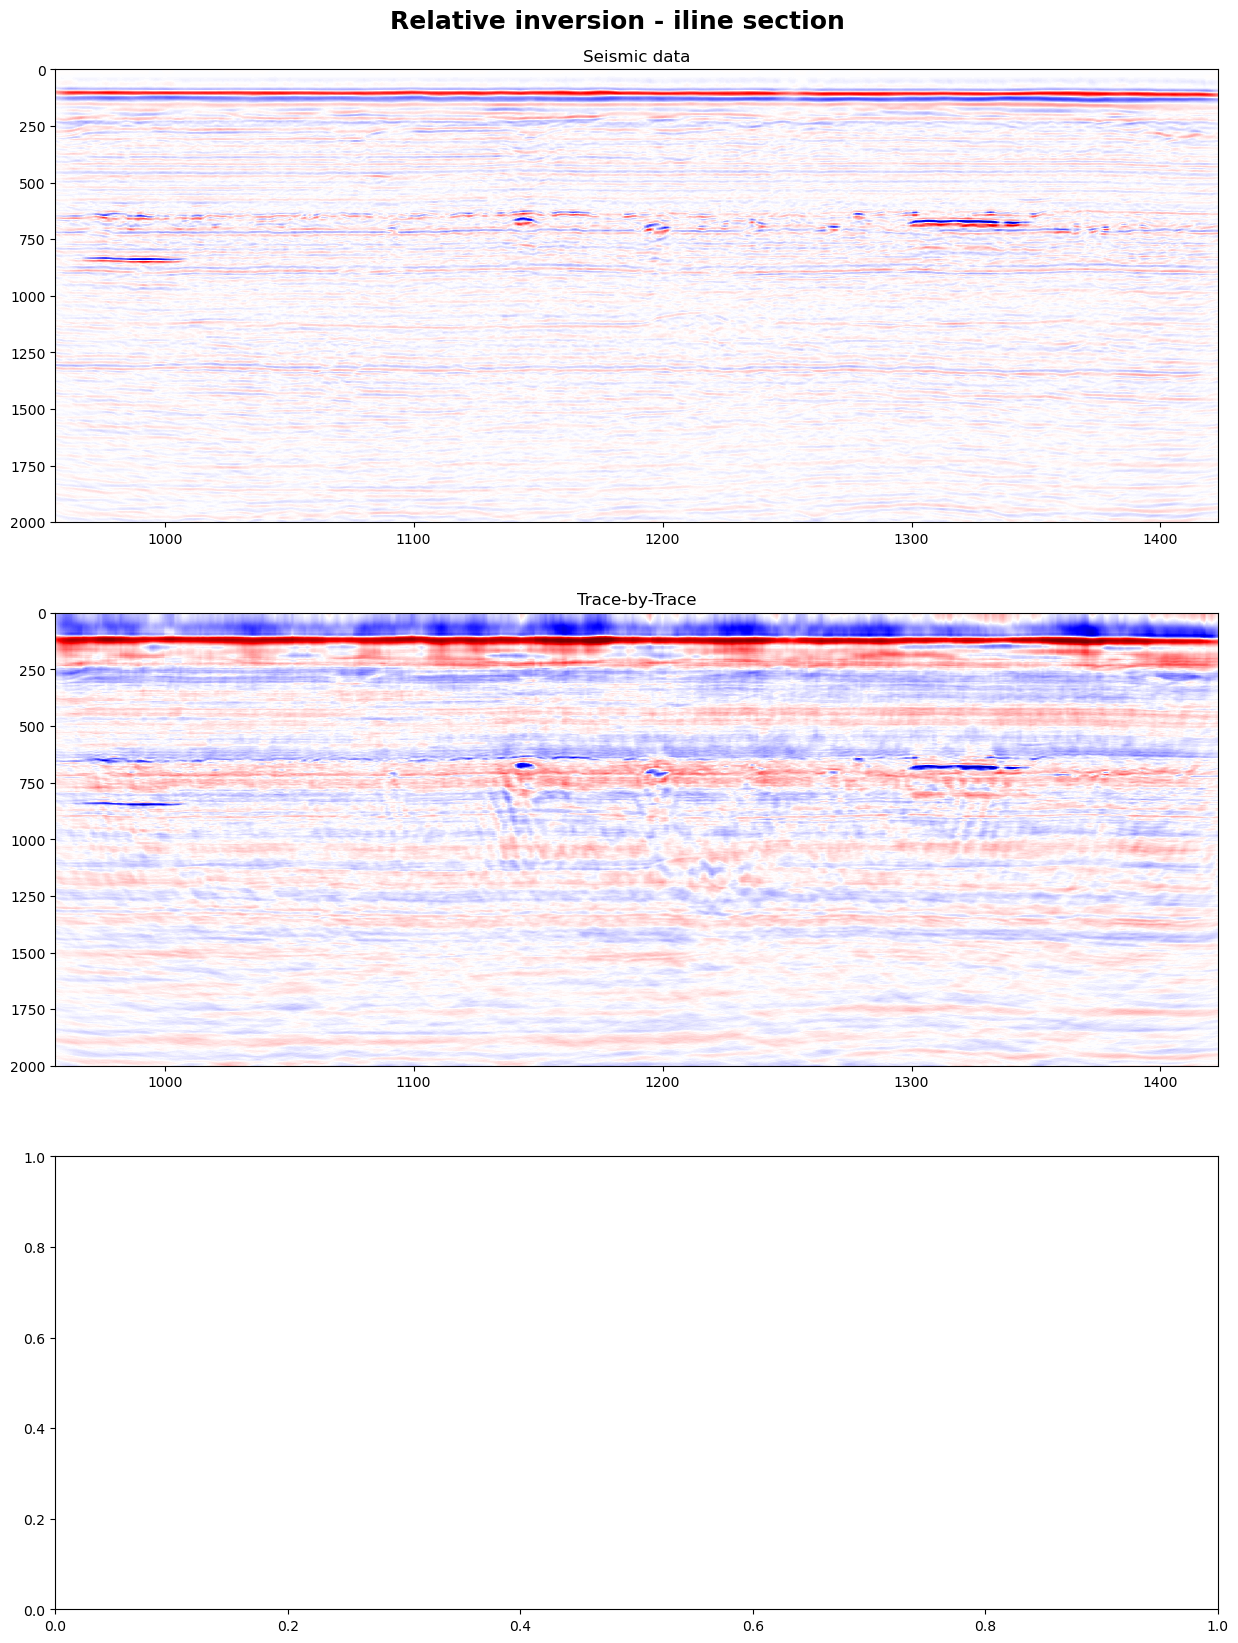

In [30]:
fig, axs = plt.subplots(3, 1, figsize=(15, 20))
itmax, itmin = int(itmax), int(itmin)
print(itmax, itmin)
fig.suptitle('Relative inversion - iline section', y=0.91, fontweight='bold', fontsize=18)

axs[0].imshow(d_small[nil//2].T, cmap='seismic', vmin=-4, vmax=4,
              extent=(xl[0], xl[-1],t[-1], t[0]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')

axs[1].imshow(m_relative_cpu[nil//2].T, cmap='seismic', vmin=-0.7*m_relative.max(), vmax=0.7*m_relative.max(),
              extent=(xl[0], xl[-1], t[-1], t[0]))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight')

# axs[2].imshow(m_relative_reg[nil//2].T, cmap='seismic', vmin=-0.7*m_relative.max(), vmax=0.7*m_relative.max(),
#               extent=(xl[0], xl[-1],t[-1], t[0]))
# axs[2].set_title('Spatially regularized')
# axs[2].axis('tight');

(1716.0, 1964.0, 2000.0, 0.0)

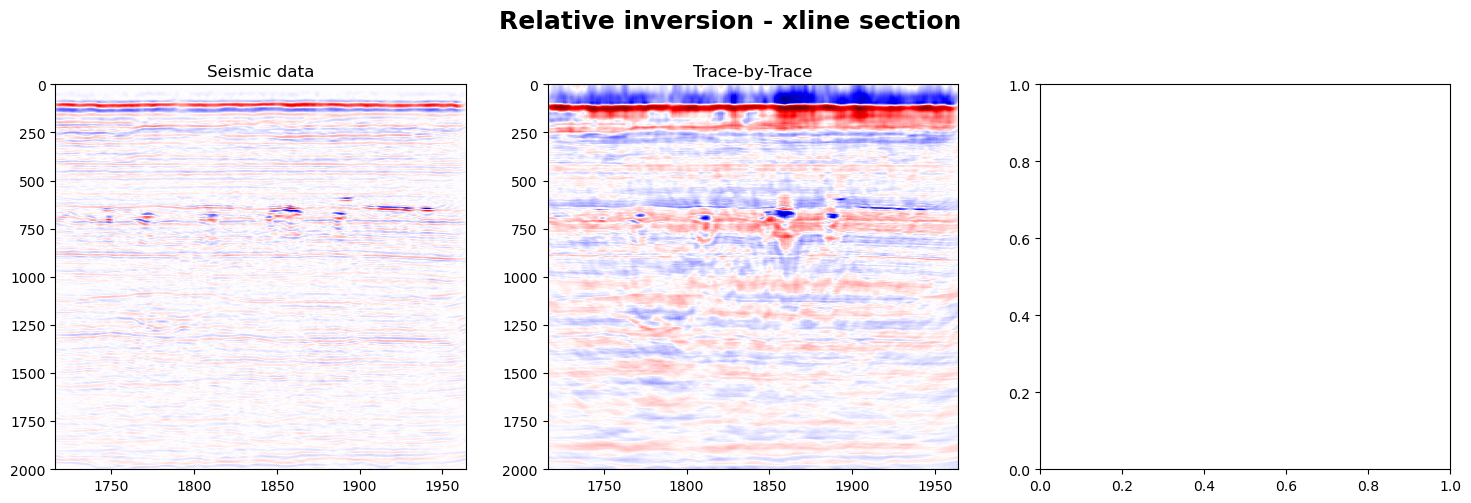

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Relative inversion - xline section', y=1.03, fontweight='bold', fontsize=18)


axs[0].imshow(d_small[:, nxl//2].T, cmap='seismic', vmin=-4, vmax=4,
              extent=(il[0], il[-1], itmax, itmin))
axs[0].set_title('Seismic data')
axs[0].axis('tight')


axs[1].imshow(m_relative_cpu[:, nxl//2].T, cmap='seismic', vmin=-0.7*m_relative.max(), vmax=0.7*m_relative.max(),
              extent=(il[0], il[-1], itmax, itmin))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight')


# axs[2].imshow(m_relative_reg[:, nxl//2].T, cmap='seismic', vmin=-0.7*m_relative.max(), vmax=0.7*m_relative.max(),
#               extent=(il[0], il[-1], itmax, itmin))
# axs[2].set_title('Spatially regularized')
# axs[2].axis('tight');

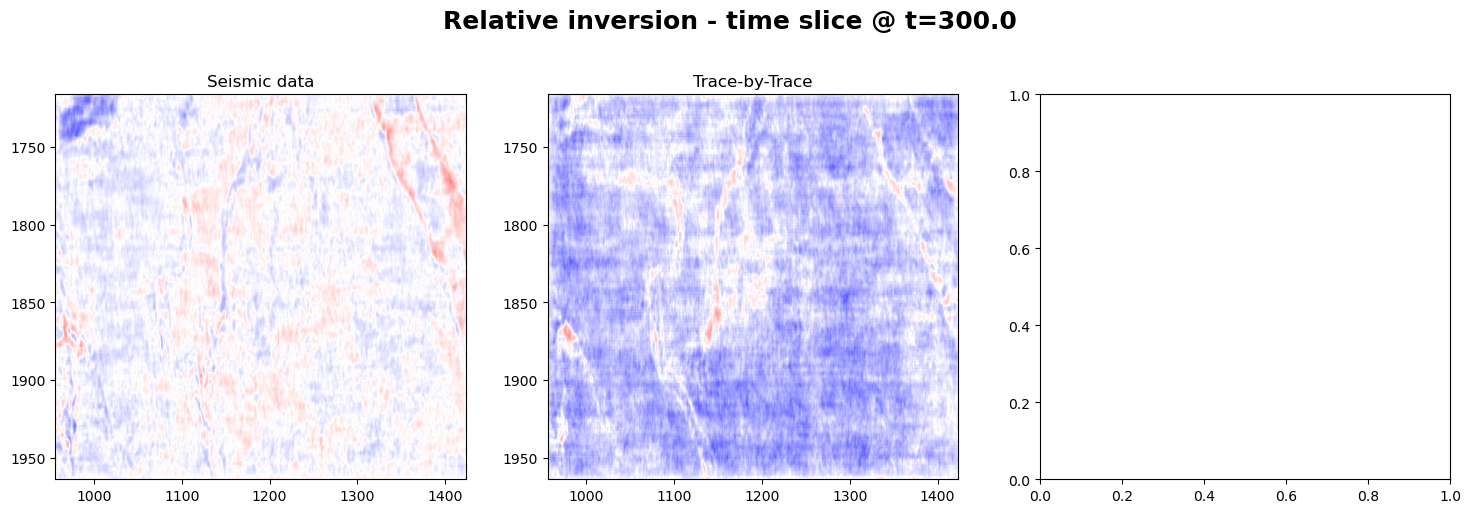

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

t_shift = 150

fig.suptitle('Relative inversion - time slice @ t={}'.format(t[itmin+t_shift]), y=1.05, fontweight='bold', fontsize=18)
axs[0].imshow(d_small[...,t_shift], cmap='seismic', vmin=-4, vmax=4,
              extent=(xl[0], xl[-1], il[-1], il[0]))
axs[0].set_title('Seismic data')
axs[0].axis('tight');
axs[1].imshow(m_relative_cpu[...,t_shift], cmap='seismic', vmin=-0.7*m_relative.max(), vmax=0.7*m_relative.max(),
              extent=(xl[0], xl[-1], il[-1], il[0]))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight');
# axs[2].imshow(m_relative_reg[...,150], cmap='seismic', vmin=-0.7*m_relative.max(), vmax=0.7*m_relative.max(),
#               extent=(xl[0], xl[-1], il[-1], il[0]))
# axs[2].set_title('Spatially regularized')
# axs[2].axis('tight');

(956.0, 1423.0, 2000.0, 0.0)

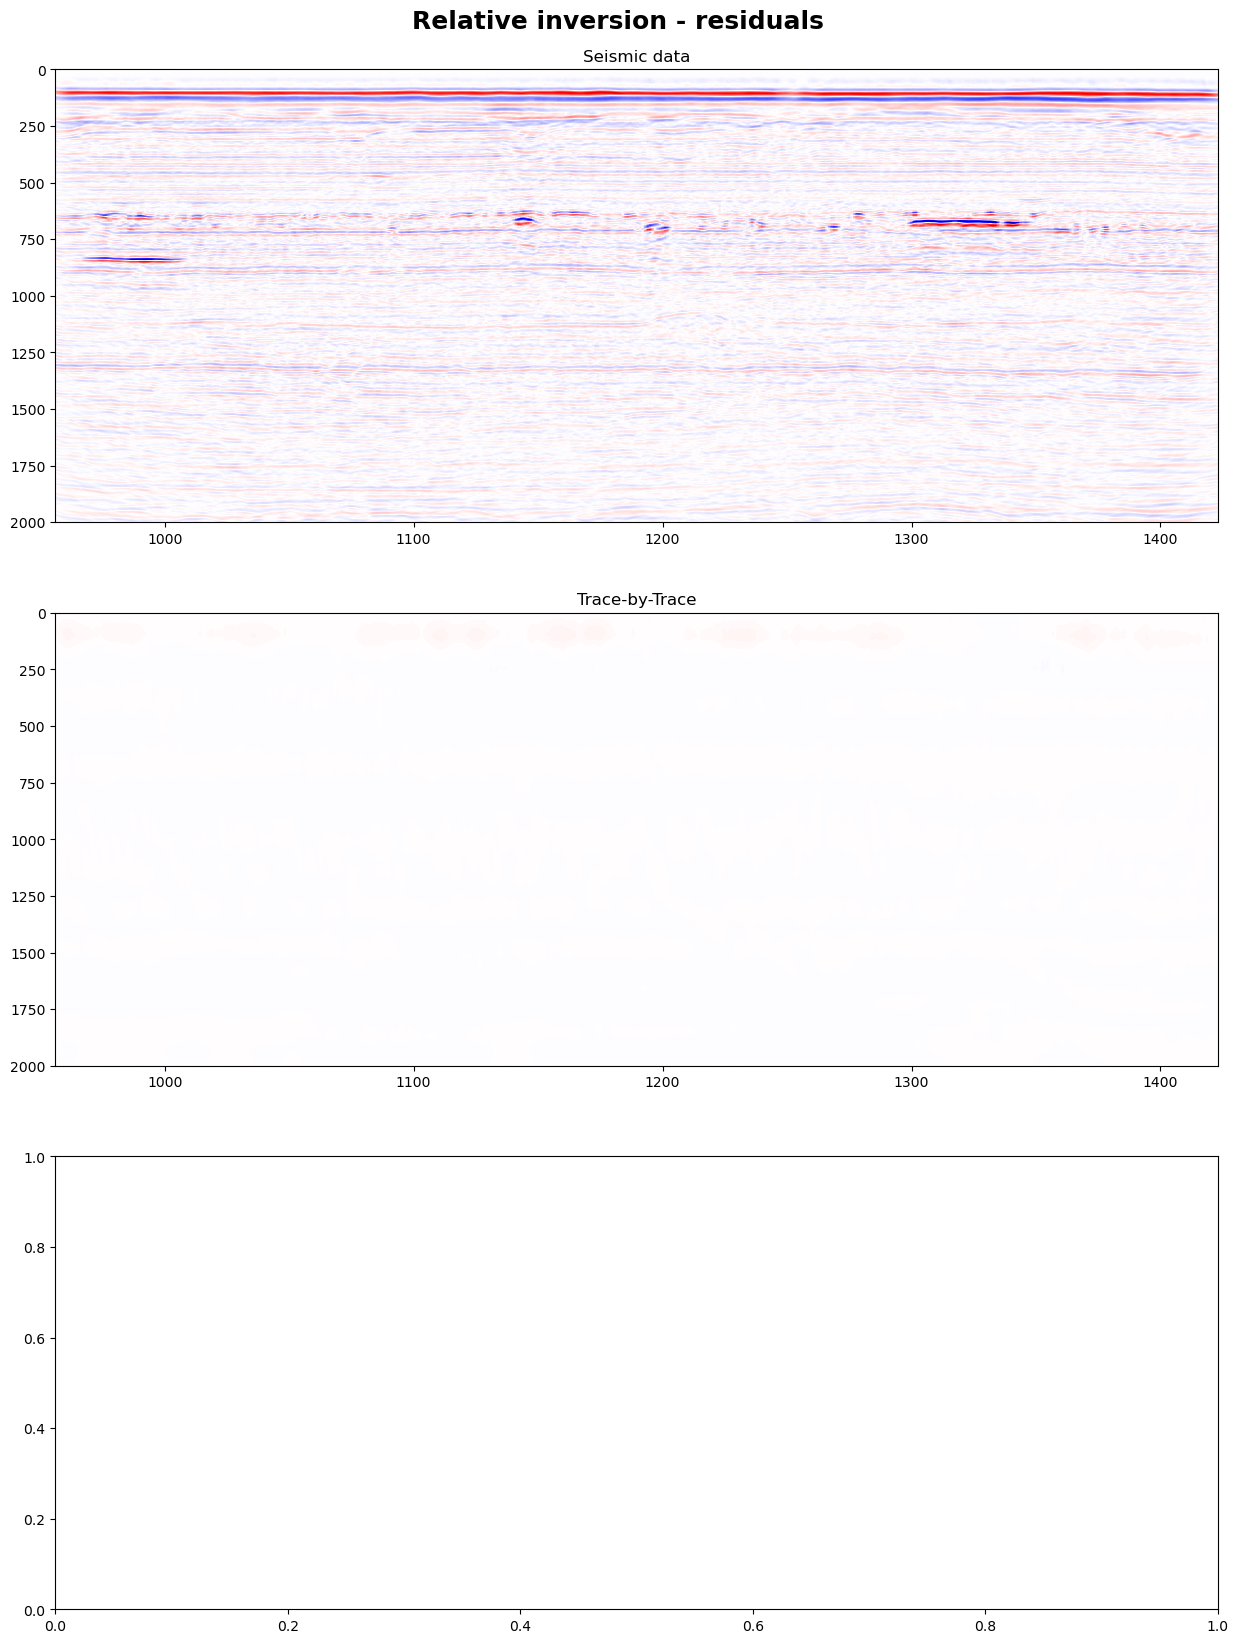

In [37]:
fig, axs = plt.subplots(3, 1, figsize=(15, 20))
fig.suptitle('Relative inversion - residuals', y=0.91, fontweight='bold', fontsize=18)
axs[0].imshow(d_small[nil//2].T, cmap='seismic', vmin=-4, vmax=4,
              extent=(xl[0], xl[-1], itmax, itmin))
axs[0].set_title('Seismic data')
axs[0].axis('tight')
axs[1].imshow(r_relative_cpu[nil//2].T, cmap='seismic', vmin=-4, vmax=4,
              extent=(xl[0], xl[-1], itmax, itmin))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight')
# axs[2].imshow(r_relative_reg[nil//2].T, cmap='seismic', vmin=-4, vmax=4,
#               extent=(xl[0], xl[-1], t[itmax], t[itmin]))
# axs[2].set_title('Spatially regularized')
# axs[2].axis('tight');

Finally we write the cube back to a segy

In [40]:
# Bring traces back to their original order and save
traces_to_save =  m_relative_cpu[ilgrid.ravel()[traces_available.ravel()], #m_relative_reg
                                 xlgrid.ravel()[traces_available.ravel()]]
np.save("backup_tts.npy", traces_to_save)

In [42]:
segyfile_inverted = './inverted.segy'
from alive_progress import alive_bar;import time
with segyio.open(segyfile, ignore_geometry=True) as src:
        spec = segyio.spec()
        spec.format = int(src.format)
        spec.samples = t[itmin:itmax]
        spec.tracecount = src.tracecount
        print("spec done...")
        with segyio.open(segyfile_inverted, "r+") as dst:
            # Copy all textual headers, including possible extended
            # for i in range(src.ext_headers):
            #     dst.text[i] = src.text[i]

            # # Copy the binary header, then insert the modifications needed for the new time axis
            # dst.bin = src.bin
            # dst.bin = {segyio.BinField.Samples: itmax-itmin}
            
            # # Copy all trace headers to destination file
            # dst.header = src.header 

            # Copy data and modify trace header
            from tqdm import tqdm_notebook
            for itrace in tqdm_notebook(range(dst.tracecount)):
                dst.header[itrace] = {segyio.TraceField.TRACE_SAMPLE_COUNT: itmax-itmin} 
                dst.trace[itrace] = traces_to_save[itrace].astype('float32')

spec done...


on 0: C:\Users\babay\AppData\Local\Temp\ipykernel_5744\2173512182.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
      Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
        for itrace in tqdm_notebook(range(dst.tracecount)):


  0%|          | 0/116532 [00:00<?, ?it/s]

|⚠︎                                       | (!) 0/116532 [0%] in 1:35.6 (0.00/s) 


Again, let's read the file back and check that what we saved is correct

In [43]:
f1 = segyio.open(segyfile_inverted, ignore_geometry=True)
traces1 = segyio.collect(f1.trace)[:]

np.allclose(traces1, traces_to_save)

True

In [ ]:
from tqdm import tqdm_notebook
for i in tqdm_notebook(range(20)):
        time.sleep(0.01)

C:\Users\babay\AppData\Local\Temp\ipykernel_19808\3978203110.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(20)):


  0%|          | 0/20 [00:00<?, ?it/s]

NameError: name 'time' is not defined

In [ ]:
import pyvista as pv


ModuleNotFoundError: No module named 'pyvista'

# Notebook #1

In [5]:
d_small = np.load("d_small.npy").astype(dtype)
m_relative = np.load("m_relative.npy").astype(dtype)
r_relative = np.load("r_relative.npy").astype(dtype)
wav_est = np.load("wav_est.npy").astype(dtype)

d_small = np.swapaxes(d_small, -1, 0)
m_relative = np.swapaxes(m_relative, -1, 0)
r_relative = np.swapaxes(r_relative, -1, 0)
d_small_cp = cp.asarray(d_small.astype(dtype))
wav_est_cp = cp.asarray(wav_est.astype(dtype))
m_relative_cp = cp.asarray(m_relative.astype(dtype))
m_relative_reg, r_relative_reg = PoststackInversion(d_small, wav_est, m0=m_relative, explicit=False,
                                                    epsR=np.sqrt(1e2).astype(dtype), **dict(engine='pylops', damp=np.sqrt(1e-2).astype(dtype), niter=50, show = 2))

ValueError: cannot reshape array of size 0 into shape (249,468,1001)